# ResNet50 Attack Demo

## Import modules

In [4]:
import torchvision.models as models
from torchvision import transforms
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
import os
import PIL
import scipy.misc
from matplotlib.pyplot import imshow

## Load the image

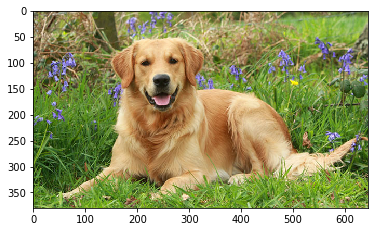

In [5]:
img_path = "/Users/zetong/robustnessdoc/RobustnessDoc/retriver.jpg"
pil_im = Image.open(img_path, 'r')
imshow(np.asarray(pil_im))

## Image data preprocessing functions

In [6]:
def processing(img_path):
    img = Image.open(img_path)
    preprocess = transforms.Compose(
        [transforms.Resize((224, 224)), transforms.ToTensor()]
    )
    img_tensor = preprocess(img)[None, :, :, :]
    return img_tensor


# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)

    def forward(self, x):
        return (x - self.mean.type_as(x)[None, :, None, None]) / self.std.type_as(x)[
            None, :, None, None
        ]

## Function to load the pretrained ResNet50 and prediction function

In [8]:
def get_resnet50():
    model = models.resnet50(pretrained=True)
    model.eval()
    return model

# img_tensor is numpy array
def predict(model, img_tensor):
    img_tensor = torch.tensor(img_tensor)
    norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    pred = model(norm(img_tensor))
    return pred.max(dim=1)[1].item()

## Loss gradient attack implementation

In [9]:
class loss_objective_attack:
    def __init__(self, model, epsilon=2.0 / 255):
        self.model = model
        self.epsilon = epsilon

    def untargeted_attack(self, x, true_label, iteration=30, learning_rate=1e-1):
        norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        delta = torch.zeros_like(x, requires_grad=True)
        opt = optim.SGD([delta], lr=learning_rate)

        for t in range(iteration):
            pred = self.model(norm(x + delta))
            loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([true_label]))
            if t % 5 == 0:
                print("loss at iteration", t, ":", loss.item())

            opt.zero_grad()
            loss.backward()
            opt.step()
            delta.data.clamp_(-self.epsilon, self.epsilon)
        x_adv = (x + delta).detach()
        adv_label = predict(self.model, x_adv)
        if adv_label != true_label:
            print(
                "attack sucessful! returning adversarial examples, adversarial label class: ",
                adv_label,
            )
            return x_adv[0].numpy()
        else:
            print("attack failed!")
            return None

    def targeted_attack(
        self, x, true_label, target_label, iteration=30, learning_rate=1e-1
    ):
        norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        delta = torch.zeros_like(x, requires_grad=True)
        opt = optim.SGD([delta], lr=learning_rate)

        for t in range(iteration):
            pred = model(norm(x + delta))
            loss = -nn.CrossEntropyLoss()(
                pred, torch.LongTensor([true_label])
            ) + nn.CrossEntropyLoss()(pred, torch.LongTensor([target_label]))
            if t % 5 == 0:
                print("loss at iteration", t, ":", loss.item())

            opt.zero_grad()
            loss.backward()
            opt.step()
            delta.data.clamp_(-self.epsilon, self.epsilon)
        x_adv = (x + delta).detach()
        if predict(self.model, x_adv) == target_label:
            print("attack sucessful!")
            return x_adv[0].numpy()
        else:
            print("attack failed!")
            return None


def save_image_from_nparray(nparray, file_name):
    scipy.misc.imsave(file_name, nparray.transpose(1, 2, 0))

## Initiate the attack

In [10]:
# load model
model = get_resnet50()
attack = loss_objective_attack(model, epsilon=2.0 / 255)
x = processing(img_path)
# true label is 207, target label is 888
x_adv = attack.targeted_attack(x, 207, 888, iteration=30)

loss at iteration 0 : 13.131396293640137
loss at iteration 5 : -3.7299728393554688
loss at iteration 10 : -6.535360336303711
loss at iteration 15 : -7.241591453552246
loss at iteration 20 : -8.128361701965332
loss at iteration 25 : -7.346702575683594


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


attack sucessful!


## Now the ResNet50 thinks our adversarial sample is a viaduct (a bridge)

In [21]:
print("the label of the original image is: ", predict(model, x))
print("the label of the adversarial image is: ", predict(model, x_adv))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


the label of the original image is:  207
the label of the adversarial image is:  888


## Generated adversarial sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


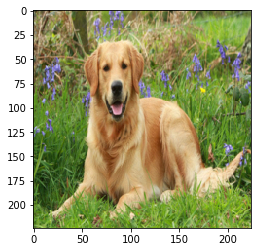

In [20]:
imshow(x_adv.transpose(1, 2, 0))